In [1]:
import sys
sys.path.append('../')

import typing as tp

import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def imshow(image: np.array, title: tp.Optional[str] = None):
    if image.ndim == 2:
        plt.gray()
    plt.imshow(image)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()

# 8 bit sRGB

In [3]:
def read_image_srgb(img_path: str) -> np.array:
    """Read image in sRGB (output.dtype = np.uint8)"""
    image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

[OpenCV читает изображение в sRGB](https://stackoverflow.com/questions/67198601/transform-image-from-bgr-to-srgb-in-numpy-opencv) (но с обратным порядком каналов, BGR - для их правильного упорядочения используется `cv2.cvtColor()`)

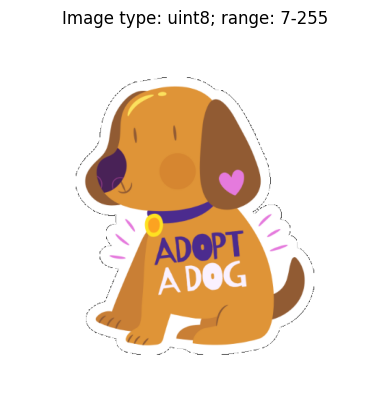

In [4]:
image_srgb = read_image_srgb('/home/chaganovaob/edu//deconv-data/deconvolution-benchmark/data/icons_jpg/1/adopt.png')
imshow(image_srgb, title=f'Image type: {image_srgb.dtype}; range: {image_srgb.min()}-{image_srgb.max()}')

# 16 bit linear RGB

[Источник](https://entropymine.com/imageworsener/srgbformula/)

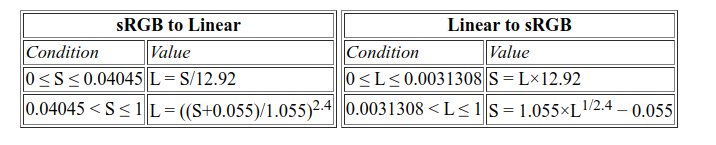

In [5]:
def convert_srgb8_to_linrgb16(image_srgb: np.array) -> np.array:
    """Convert 8-bit sRGB to 16-bit linRGB"""
    
    if image_srgb.dtype == np.uint8:
        image_srgb = image_srgb / 255
        
    mask = image_srgb <= 0.04045

    image_srgb[mask] = image_srgb[mask] / 12.92
    image_srgb[np.invert(mask)] = np.power((image_srgb[np.invert(mask)] + 0.055) / 1.055, 2.4)
    return (image_srgb * 65535).astype(np.uint16)

### Пример 1

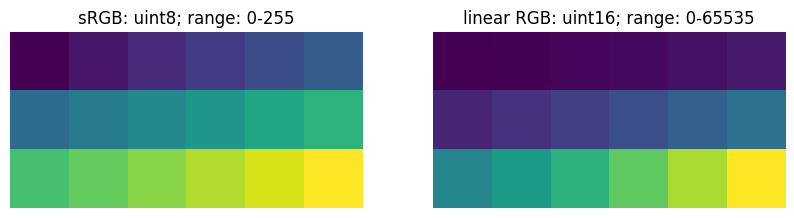

In [6]:
image_srgb = np.arange(0, 256, step=15, dtype=np.uint8).reshape(-1, 6)
image_lin = convert_srgb8_to_linrgb16(image_srgb)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image_srgb)
axs[0].set_title(f'sRGB: {image_srgb.dtype}; range: {image_srgb.min()}-{image_srgb.max()}')
axs[0].axis('off')

axs[1].imshow(image_lin)
axs[1].set_title(f'linear RGB: {image_lin.dtype}; range: {image_lin.min()}-{image_lin.max()}')
axs[1].axis('off')

plt.show()

In [8]:
image_srgb

array([[  0,  15,  30,  45,  60,  75],
       [ 90, 105, 120, 135, 150, 165],
       [180, 195, 210, 225, 240, 255]], dtype=uint8)

In [7]:
image_lin

array([[    0,   313,   850,  1719,  2961,  4611],
       [ 6700,  9257, 12308, 15877, 19987, 24658],
       [29910, 35764, 42235, 49344, 57105, 65535]], dtype=uint16)

### Пример 2

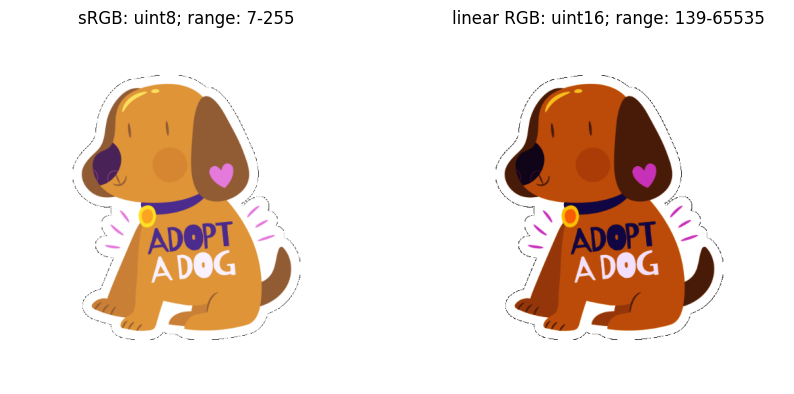

In [9]:
image_srgb = read_image_srgb('/home/chaganovaob/edu//deconv-data/deconvolution-benchmark/data/icons_jpg/1/adopt.png')
image_lin = convert_srgb8_to_linrgb16(image_srgb)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image_srgb)
axs[0].set_title(f'sRGB: {image_srgb.dtype}; range: {image_srgb.min()}-{image_srgb.max()}')
axs[0].axis('off')

axs[1].imshow(image_lin / image_lin.max())  # нормировка для визуализации в matplotlibe
axs[1].set_title(f'linear RGB: {image_lin.dtype}; range: {image_lin.min()}-{image_lin.max()}')
axs[1].axis('off')

plt.show()

# Wiener

## code

Свертка изображений через FFT

In [10]:
import logging
import typing as tp

import numpy as np
import torch


def fft(inp: np.array, shape: tuple = None) -> np.array:
    if shape is None:
        shape = inp.shape
    spectrum = np.fft.fft2(inp, s=shape, norm='ortho')
    return spectrum


def ifft(inp: np.array, shape: tuple = None) -> np.array:
    if shape is None:
        shape = inp.shape
    res = np.fft.ifft2(inp, s=shape, norm='ortho')
    return res


def shift(inp: np.array, inverse: bool = False) -> np.array:
    if inverse:
        return np.fft.ifftshift(inp)
    else:
        return np.fft.fftshift(inp)


def fft_conv(image: np.array, psf: np.array, scale_output: bool = True) -> np.array:
    if image.shape != psf.shape:
        sz = (image.shape[0] - psf.shape[0], image.shape[1] - psf.shape[1])
        psf = np.pad(
            psf,
            (((sz[0] + 1) // 2, sz[0] // 2), ((sz[1] + 1) // 2, sz[1] // 2)),
            'constant'
        )
    f1 = fft(image)
    f2 = fft(psf, shape=image.shape)
    convolved = ifft(f1 * f2, shape=image.shape)
    res = np.abs(convolved)
    if scale_output:
        res = res * np.sum(image) / np.sum(res)
    return shift(res)


def convolve(
    image: np.array,
    psf: np.array,
    scale_output: bool = True,
    data_type: tp.Any = np.float32
) -> np.array:
    """Convolve multichannel images using FFT."""

    if not np.allclose(psf.sum(), 1.0, atol=1e-5):
        psf = psf / psf.sum()
        logging.warning('PSF has sum more than 1. Normed')

    ndim = image.ndim

    if ndim == 2:
        return fft_conv(image, psf, scale_output).astype(data_type)

    elif ndim == 3:
        res = []
        for i in range(image.shape[-1]):
            res.append(fft_conv(image[..., i], psf, scale_output=scale_output))
        res = np.stack(res)
        return np.transpose(res, (1, 2, 0)).astype(data_type)

    else:
        raise ValueError(f'Image must be 2- or 3-dimencional but got {ndim}-dimencional image.')

Винеровский фильтр

In [11]:
from skimage import restoration


def wiener_rgb(blurred_image: np.array, psf: np.array, **algo_params) -> np.array:
    """Apply Wiener deconvolution for RGB image per channel.

    Parameters
    ----------
    blurred_image : np.array
        Blurred RGB image.
    psf : np.array
        PSF.

    Returns
    -------
    np.array
        Restored RGB image.
    """
    rgb_restored = []
    for i in range(blurred_image.shape[-1]):
        restored = restoration.wiener(blurred_image[:, :, i], psf, **algo_params)
        rgb_restored.append(restored)
    rgb_restored = np.stack(rgb_restored)
    return np.transpose(rgb_restored, (1, 2, 0))

## results

### 1) 8-bit sRGB

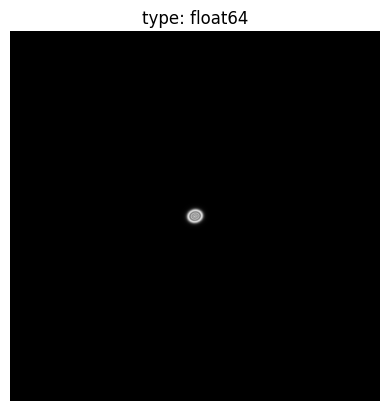

In [12]:
psf = np.load('/home/chaganovaob/edu/deconv-data/deconvolution-benchmark/data/psf/psf/small_psf_1.npy', allow_pickle=True)[0]['psf']
psf = psf / psf.sum()

imshow(psf, title=f'type: {psf.dtype}')

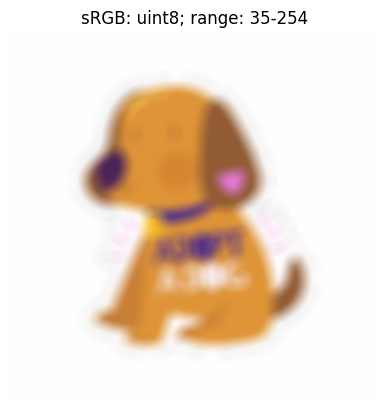

In [13]:
# 1. чтение изображения в 8-bit sRGB 
image = read_image_srgb('/home/chaganovaob/edu//deconv-data/deconvolution-benchmark/data/icons_jpg/1/adopt.png')  # --> 8-bit sRGB

# 2. свертка через FFT 
blurred_srgb = convolve(image=image, psf=psf, scale_output=True, data_type=image.dtype) # image: 8-bit sRGB, psf: float64  -->  blurred: 8-bit sRGB


imshow(blurred_srgb, title=f'sRGB: {blurred_srgb.dtype}; range: {blurred_srgb.min()}-{blurred_srgb.max()}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


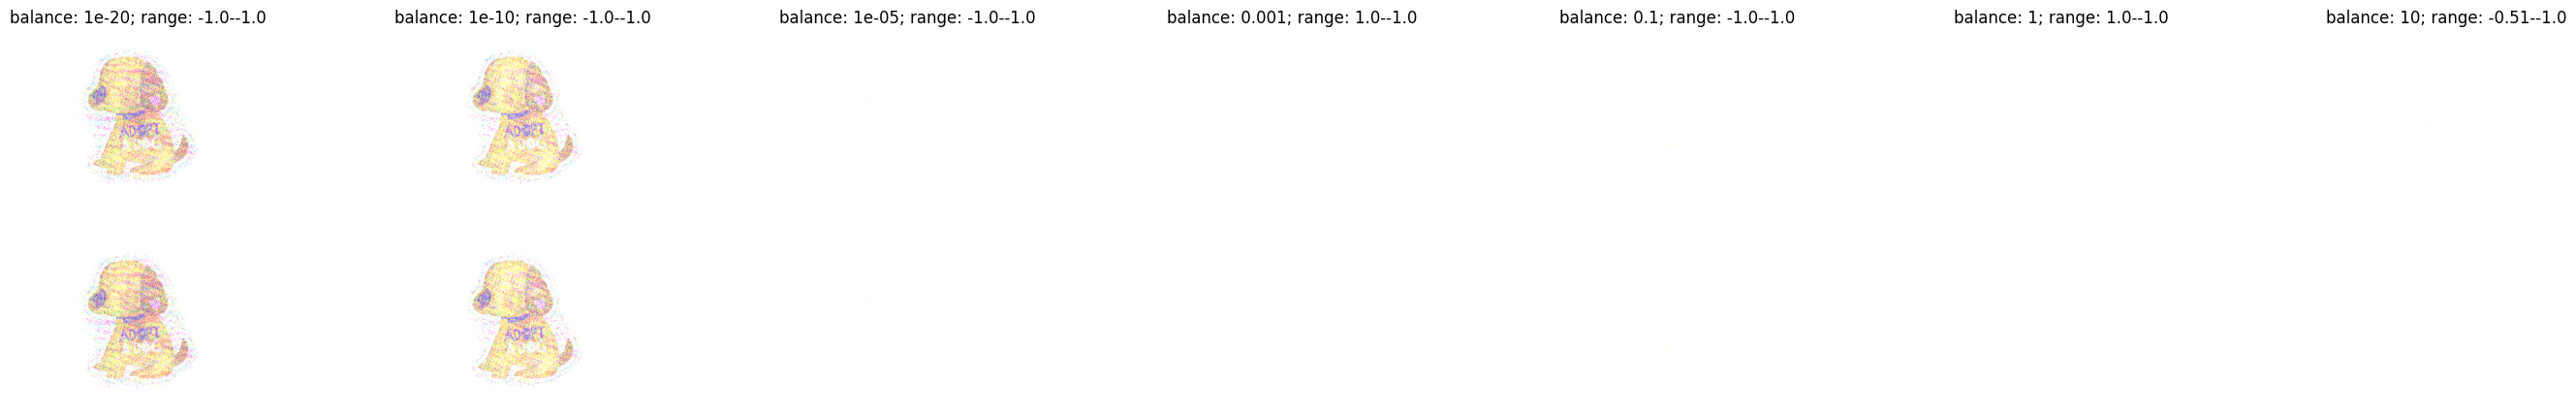

In [14]:
balances = [1e-20, 1e-10, 1e-5, 1e-3, 1e-1, 1, 10]

fig, axs = plt.subplots(2, len(balances), figsize=(5 * len(balances), 5))
for i, balance in enumerate(balances):

    # 3. винеровский фильтр
    restored_srgb = wiener_rgb(blurred_srgb, psf, balance=balance) # blurred: 8-bit sRGB, psf: float64 ---winer---> restored: float64
    
    axs[0, i].imshow(restored_srgb)  # первый ряд -- визуализация как есть
    axs[0, i].axis('off')
    axs[0, i].set_title(f'balance: {balance}; range: {round(restored_srgb.min(), 2)}--{round(restored_srgb.max(), 2)}')
    axs[1, i].imshow((restored_srgb + 1) / 2) # второй ряд -- визуализация с нормировкой (приведение к 0..1)
    axs[1, i].axis('off')

### 2) 16-bit linear RGB

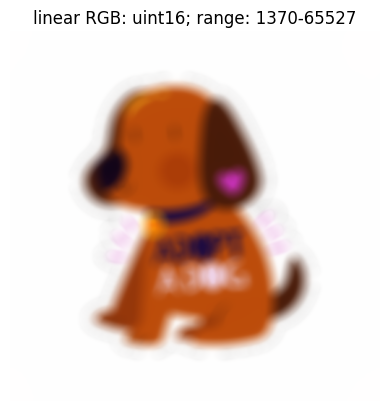

In [15]:
# 1. чтение изображения в 16-bit linear RGB 
image_lin = read_image_srgb('/home/chaganovaob/edu//deconv-data/deconvolution-benchmark/data/icons_jpg/1/adopt.png')
image_lin = convert_srgb8_to_linrgb16(image_lin)

# 2. свертка через FFT 
blurred_lin = convolve(image=image_lin, psf=psf, scale_output=True, data_type=image_lin.dtype) # image: 16-bit linear RGB , psf: float64  -->  blurred: 16-bit linear RGB 

imshow(blurred_lin / blurred_lin.max(), title=f'linear RGB: {blurred_lin.dtype}; range: {blurred_lin.min()}-{blurred_lin.max()}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


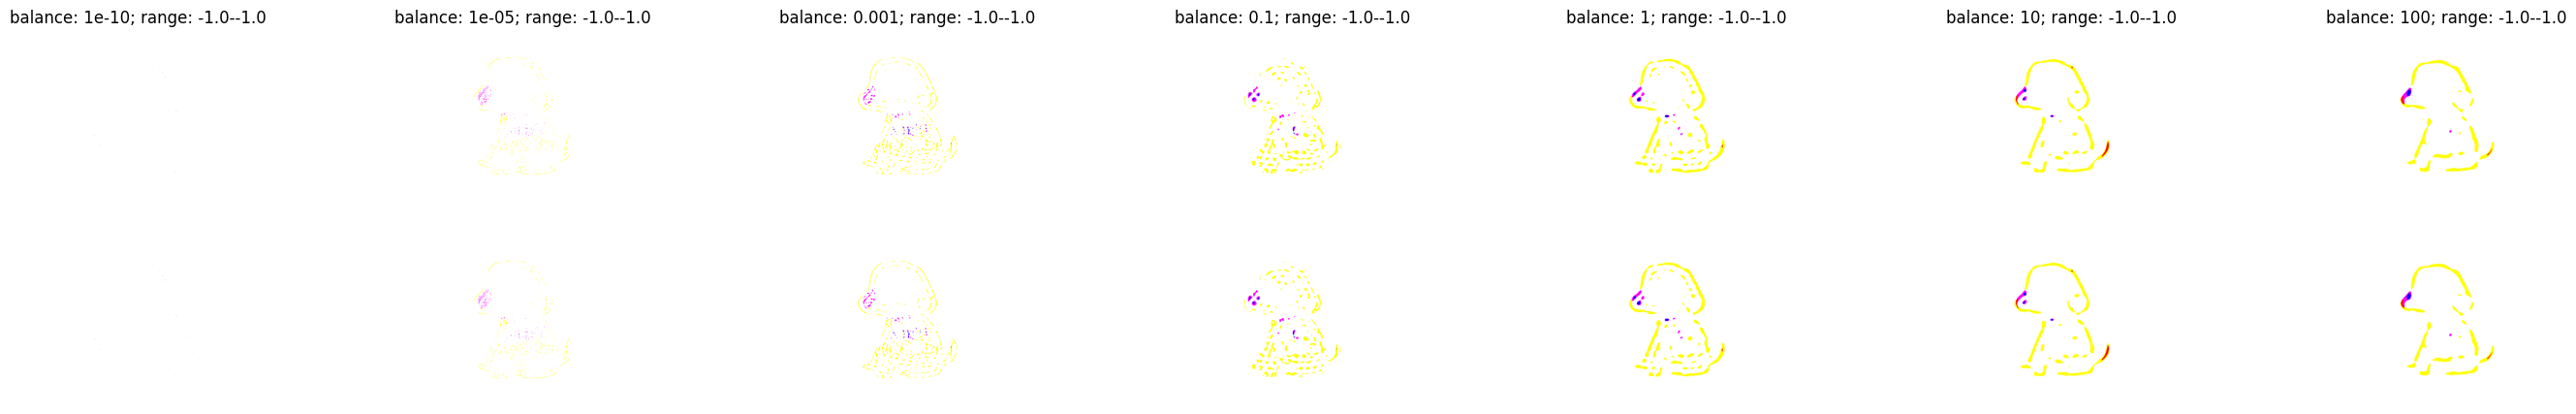

In [16]:
balances = [1e-10, 1e-5, 1e-3, 1e-1, 1, 10, 100]

fig, axs = plt.subplots(2, len(balances), figsize=(5 * len(balances), 5))
for i, balance in enumerate(balances):
    
    # 3. винеровский фильтр
    restored_lin = wiener_rgb(blurred_lin, psf, balance=balance) # blurred: 16-bit linear RGB, psf: float64 ---winer---> restored: float64

    axs[0, i].imshow(restored_lin)  # первый ряд -- визуализация как есть
    axs[0, i].axis('off')
    axs[0, i].set_title(f'balance: {balance}; range: {round(restored_lin.min(), 2)}--{round(restored_lin.max(), 2)}')
    axs[1, i].imshow((restored_lin + 1) / 2) # второй ряд -- визуализация с нормировкой (приведение к 0..1)
    axs[1, i].axis('off')